# Start to end test

Before runing this test, please download models from [https://nomeroff.net.ua/models/](https://nomeroff.net.ua/models/) to **./models/** directory. 

In [1]:
import os
import sys
import json
import numpy as np
import cv2
from matplotlib import pyplot as plt
from termcolor import colored
import warnings
import time
import keras
warnings.filterwarnings('ignore')

# change this property
NOMEROFF_NET_DIR = os.path.abspath('../')

# specify the path to Mask_RCNN if you placed it outside Nomeroff-net project
MASK_RCNN_DIR = os.path.join(NOMEROFF_NET_DIR, 'Mask_RCNN')

MASK_RCNN_LOG_DIR = os.path.join(NOMEROFF_NET_DIR, 'logs')
MASK_RCNN_MODEL_PATH = os.path.join(NOMEROFF_NET_DIR, "models/mask_rcnn_numberplate_0640_2019_06_24.h5")
OPTIONS_MODEL_PATH =  os.path.join(NOMEROFF_NET_DIR, "models/numberplate_options_2019_05_20.h5")

mode = "cpu"
OCR_NP_UKR_TEXT = os.path.join(NOMEROFF_NET_DIR, "models/anpr_ocr_ua_12-{}.h5".format(mode))
OCR_NP_EU_TEXT =  os.path.join(NOMEROFF_NET_DIR, "models/anpr_ocr_eu_2-{}.h5".format(mode))
OCR_NP_RU_TEXT =  os.path.join(NOMEROFF_NET_DIR, "models/anpr_ocr_ru_3-{}.h5".format(mode))
OCR_NP_KZ_TEXT =  os.path.join(NOMEROFF_NET_DIR, "models/anpr_ocr_kz_4-{}.h5".format(mode))

sys.path.append(NOMEROFF_NET_DIR)

# Import license plate recognition tools.
from NomeroffNet import  filters, RectDetector, TextDetector, OptionsDetector, Detector, textPostprocessing, textPostprocessingAsync

# Initialize npdetector with default configuration file.
nnet = Detector(MASK_RCNN_DIR, MASK_RCNN_LOG_DIR)
nnet.loadModel(MASK_RCNN_MODEL_PATH)

rectDetector = RectDetector()

optionsDetector = OptionsDetector({
    "class_region": ["xx_unknown", "eu_ua_2015", "eu_ua_2004", "eu_ua_1995", "eu", "xx_transit", "ru", "kz"]
})
optionsDetector.load(OPTIONS_MODEL_PATH)


# Initialize text detector.
textDetector = TextDetector({
    "eu_ua_2004_2015": {
        "for_regions": ["eu_ua_2015", "eu_ua_2004"],
        "model_path": OCR_NP_UKR_TEXT
    },
    "eu": {
        "for_regions": ["eu", "eu_ua_1995"],
        "model_path": OCR_NP_EU_TEXT
    },
    "ru": {
        "for_regions": ["ru"],
        "model_path": OCR_NP_RU_TEXT
    },
    "kz": {
        "for_regions": ["kz"],
        "model_path": OCR_NP_KZ_TEXT
    }
})

Using TensorFlow backend.
W0704 10:12:54.799807 140511690446144 deprecation_wrapper.py:119] From /mnt/data/www/nomeroff-net/NomeroffNet/Detector.py:12: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0704 10:12:54.801651 140511690446144 deprecation_wrapper.py:119] From /mnt/data/www/nomeroff-net/NomeroffNet/Detector.py:14: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0704 10:12:56.543926 140511690446144 deprecation_wrapper.py:119] From /usr/local/lib64/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0704 10:12:56.550331 140511690446144 deprecation_wrapper.py:119] From /usr/local/lib64/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0704 10:12:56.555495 140511690446144 deprecation_wrapper.py:119] From /u

In [3]:
from NomeroffNet.Base import OCR

In [4]:

class eu(OCR):
    def __init__(self):
        OCR.__init__(self)
        # only for usage model
        # in train generate automaticly
        self.letters = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]

        self.EPOCHS = 1


In [5]:
eu.load(PATH)

NameError: name 'PATH' is not defined

In [5]:
import cv2
import numpy as np

async def test(dirName, fname, y, verbose=0, max_img_w = 1000):
    img_path = os.path.join(dirName, fname)
    if verbose==1:
        print(colored(f"__________ \t\t {img_path} \t\t __________", "blue"))
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    nGood = 0
    nBad = 0
    img_path = os.path.join(dirName, fname)

    # corect size for better speed
    img_w = img.shape[1]
    img_h = img.shape[0]
    img_w_r = 1
    img_h_r = 1
    if img_w > max_img_w:
        resized_img = cv2.resize(img, (max_img_w, int(max_img_w/img_w*img_h)))
        img_w_r = img_w/max_img_w
        img_h_r = img_h/(max_img_w/img_w*img_h)
    else:
        resized_img = img

    NP = nnet.detect([resized_img]) 
    
    # Generate image mask.
    cv_img_masks = await filters.cv_img_mask_async(NP)
    if verbose:
        for m in cv_img_masks:
            plt.imshow(m)
            plt.show()
            
    # Detect points.
    arrPoints = await rectDetector.detectAsync(cv_img_masks, outboundHeightOffset=0, fixGeometry=True, fixRectangleAngle=10)
    arrPoints[..., 1:2] = arrPoints[..., 1:2]*img_h_r
    arrPoints[..., 0:1] = arrPoints[..., 0:1]*img_w_r
    
    if verbose:
        filters.draw_box(img, arrPoints, (0, 255, 0), 3)
        plt.imshow(img)
        plt.show()
    
    # cut zones
    zones = await rectDetector.get_cv_zonesBGR_async(img, arrPoints)
    toShowZones = rectDetector.get_cv_zonesRGB(img, arrPoints)
    if verbose:
        for zone, points in zip(toShowZones, arrPoints):
            plt.imshow(zone)
            plt.show()

    # find standart
    regionIds, stateIds, lines = optionsDetector.predict(zones)
    regionNames = optionsDetector.getRegionLabels(regionIds)
    if verbose:
        print(regionNames)

    # find text with postprocessing by standart  
    textArr = textDetector.predict(zones, regionNames, lines)
    textArr = await textPostprocessingAsync(textArr, regionNames)
    if verbose:
        print(textArr)
    
    for yText in y:
        if yText in textArr:
            print(colored(f"OK: TEXT:{yText} \t\t\t RESULTS:{textArr} \n\t\t\t\t\t in PATH:{img_path}", 'green'))
            nGood += 1
        else:
            print(colored(f"NOT OK: TEXT:{yText} \t\t\t RESULTS:{textArr} \n\t\t\t\t\t in PATH:{img_path} ", 'red'))
            nBad += 1
    return nGood, nBad

In [6]:
dirName = "../datasets/hackaton/ge_test"

__________ 		 ../datasets/hackaton/ge_test/38523092-38523092_1.jpg 		 __________


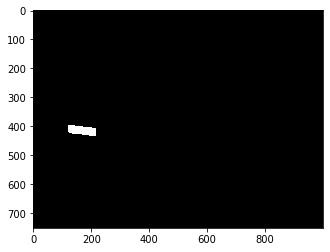

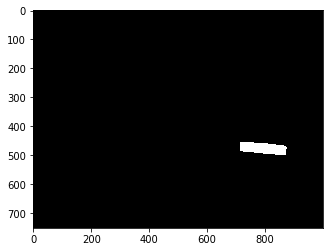

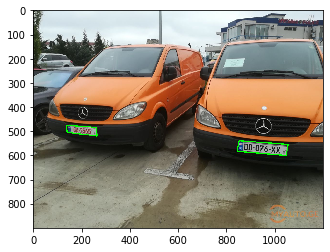

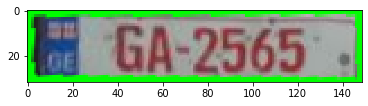

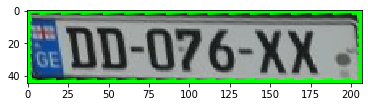

['eu', 'eu']
['GA2565', 'OO076XX']
NOT OK: TEXT:DD076XX 			 RESULTS:['GA2565', 'OO076XX'] 
					 in PATH:../datasets/hackaton/ge_test/38523092-38523092_1.jpg 
OK: TEXT:GA2565 			 RESULTS:['GA2565', 'OO076XX'] 
					 in PATH:../datasets/hackaton/ge_test/38523092-38523092_1.jpg
__________ 		 ../datasets/hackaton/ge_test/36204663-36204663_6.jpg 		 __________


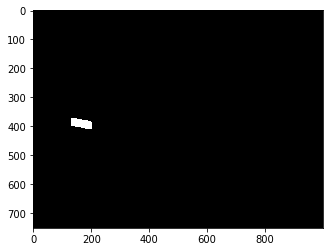

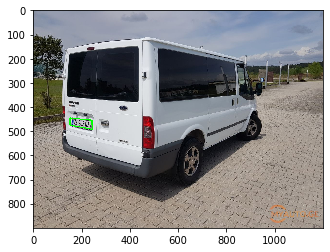

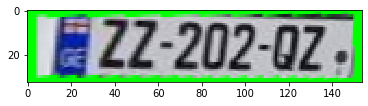

['eu']
['ZZ2020Z']
NOT OK: TEXT:ZZ202QZ 			 RESULTS:['ZZ2020Z'] 
					 in PATH:../datasets/hackaton/ge_test/36204663-36204663_6.jpg 
__________ 		 ../datasets/hackaton/ge_test/39216637-39216637_2.jpg 		 __________


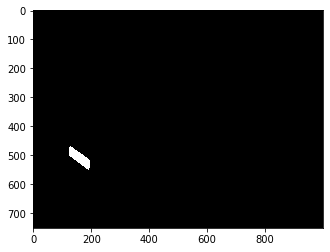

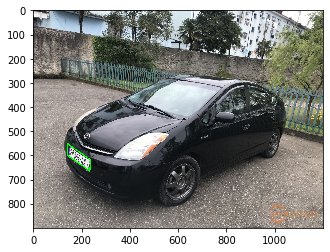

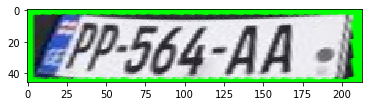

['eu']
['564AA']
NOT OK: TEXT:PP564AA 			 RESULTS:['564AA'] 
					 in PATH:../datasets/hackaton/ge_test/39216637-39216637_2.jpg 
__________ 		 ../datasets/hackaton/ge_test/38297989-38297989_4.jpg 		 __________


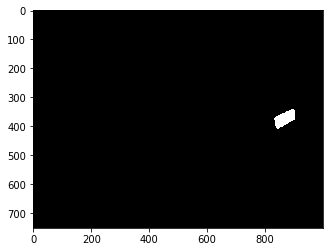

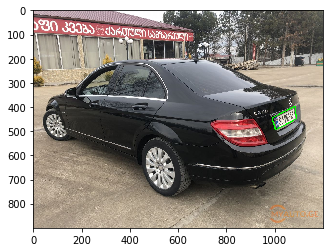

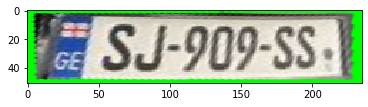

['eu_ua_2015']
['BH90933']
NOT OK: TEXT:SJ909SS 			 RESULTS:['BH90933'] 
					 in PATH:../datasets/hackaton/ge_test/38297989-38297989_4.jpg 
__________ 		 ../datasets/hackaton/ge_test/29154782-29154782_7.jpg 		 __________


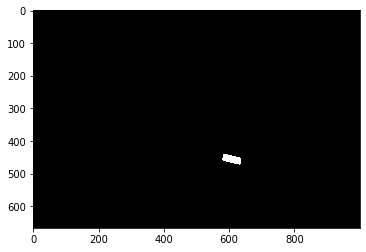

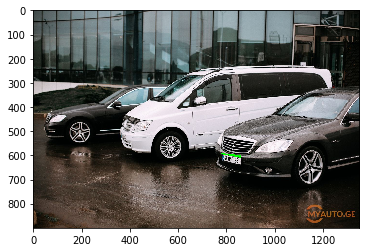

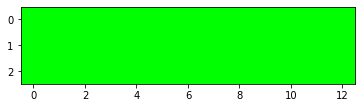

['xx_unknown']
['']
NOT OK: TEXT:SP051SS 			 RESULTS:[''] 
					 in PATH:../datasets/hackaton/ge_test/29154782-29154782_7.jpg 
__________ 		 ../datasets/hackaton/ge_test/38538422-38538422_1.jpg 		 __________


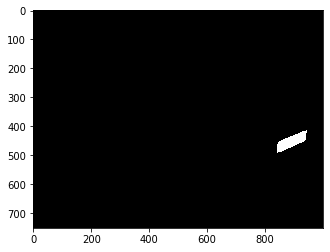

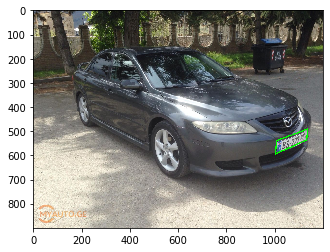

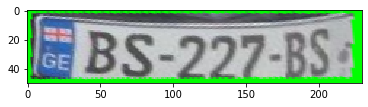

['eu_ua_2015']
['BB5422783']
NOT OK: TEXT:BS227BS 			 RESULTS:['BB5422783'] 
					 in PATH:../datasets/hackaton/ge_test/38538422-38538422_1.jpg 
__________ 		 ../datasets/hackaton/ge_test/39008915-39008915_1.jpg 		 __________


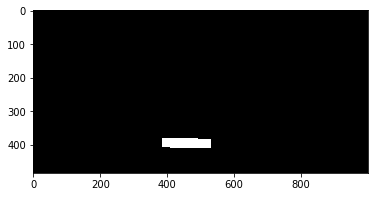

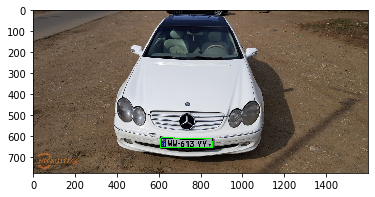

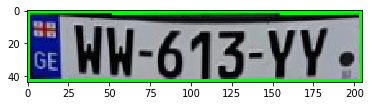

['eu']
['WW613VY']
NOT OK: TEXT:WW613YY 			 RESULTS:['WW613VY'] 
					 in PATH:../datasets/hackaton/ge_test/39008915-39008915_1.jpg 
__________ 		 ../datasets/hackaton/ge_test/39381711-39381711_1.jpg 		 __________


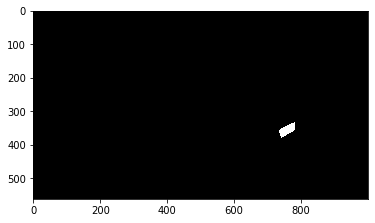

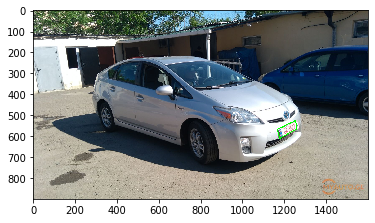

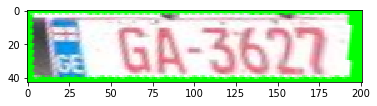

['eu_ua_2015']
['AAH3627']
NOT OK: TEXT:GA3627 			 RESULTS:['AAH3627'] 
					 in PATH:../datasets/hackaton/ge_test/39381711-39381711_1.jpg 
__________ 		 ../datasets/hackaton/ge_test/38685784-38685784_5.jpg 		 __________


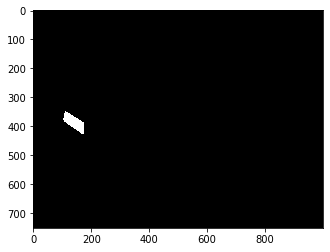

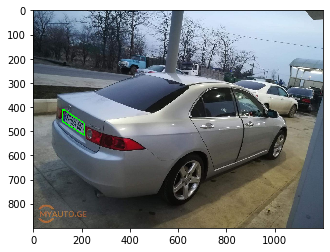

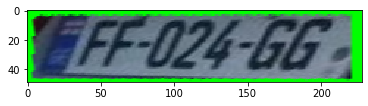

['eu']
['R42244T']
NOT OK: TEXT:FF024GG 			 RESULTS:['R42244T'] 
					 in PATH:../datasets/hackaton/ge_test/38685784-38685784_5.jpg 
__________ 		 ../datasets/hackaton/ge_test/37230942-37230942_3.jpg 		 __________


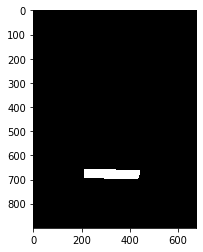

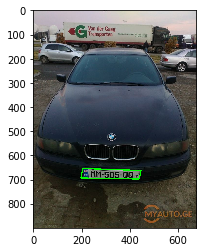

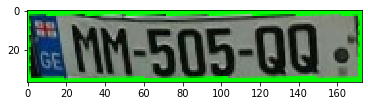

['eu']
['M50500']
NOT OK: TEXT:MM505QQ 			 RESULTS:['M50500'] 
					 in PATH:../datasets/hackaton/ge_test/37230942-37230942_3.jpg 
__________ 		 ../datasets/hackaton/ge_test/39390449-39390449_2.jpg 		 __________


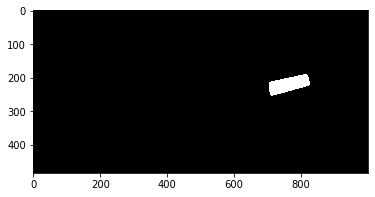

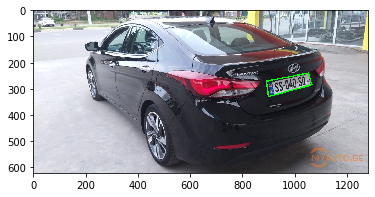

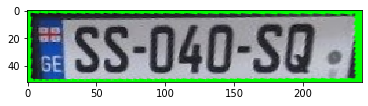

['eu']
['SS040S0']
NOT OK: TEXT:SS040SQ 			 RESULTS:['SS040S0'] 
					 in PATH:../datasets/hackaton/ge_test/39390449-39390449_2.jpg 
__________ 		 ../datasets/hackaton/ge_test/39417779-39417779_1.jpg 		 __________


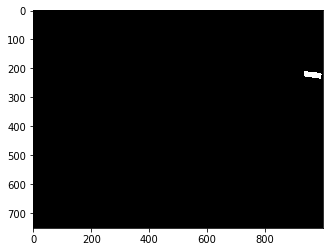

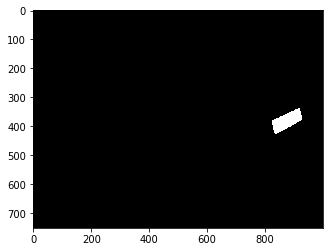

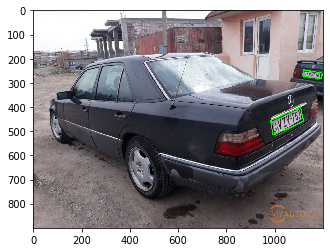

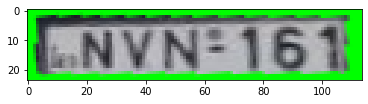

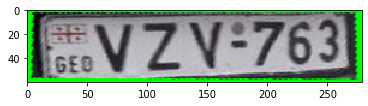

['eu', 'eu']
['NRN163', 'VZX763']
NOT OK: TEXT:VZV763 			 RESULTS:['NRN163', 'VZX763'] 
					 in PATH:../datasets/hackaton/ge_test/39417779-39417779_1.jpg 
NOT OK: TEXT:NVN161 			 RESULTS:['NRN163', 'VZX763'] 
					 in PATH:../datasets/hackaton/ge_test/39417779-39417779_1.jpg 
__________ 		 ../datasets/hackaton/ge_test/39229983-39229983_5.jpg 		 __________


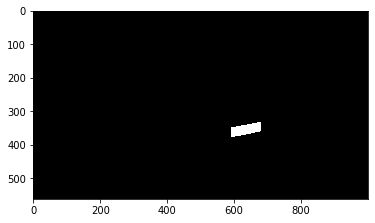

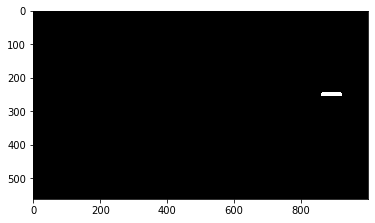

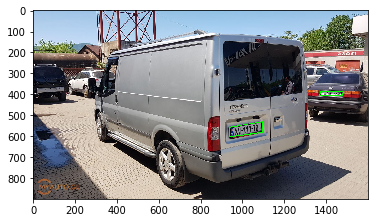

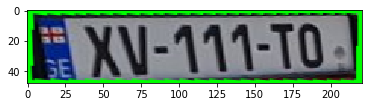

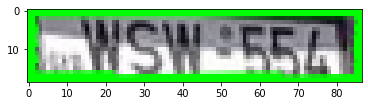

['eu', 'xx_unknown']
['XV111T0', '']
OK: TEXT:XV111T0 			 RESULTS:['XV111T0', ''] 
					 in PATH:../datasets/hackaton/ge_test/39229983-39229983_5.jpg
__________ 		 ../datasets/hackaton/ge_test/39196372-39196372_5.jpg 		 __________


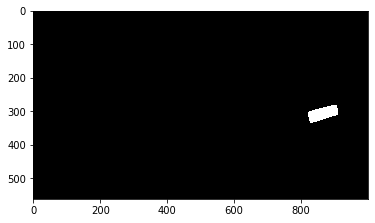

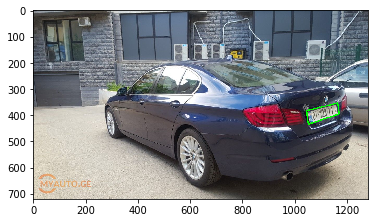

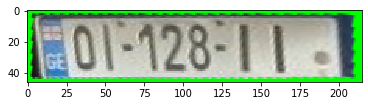

['eu_ua_2015']
['0128II']
NOT OK: TEXT:0I128II 			 RESULTS:['0128II'] 
					 in PATH:../datasets/hackaton/ge_test/39196372-39196372_5.jpg 
__________ 		 ../datasets/hackaton/ge_test/39194553-39194553_4.jpg 		 __________


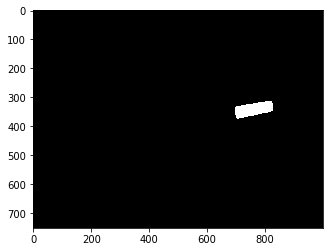

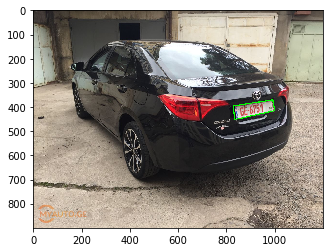

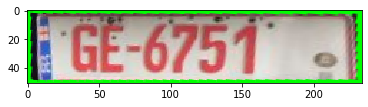

['eu_ua_2015']
['BE6751IA']
NOT OK: TEXT:GE6751 			 RESULTS:['BE6751IA'] 
					 in PATH:../datasets/hackaton/ge_test/39194553-39194553_4.jpg 
__________ 		 ../datasets/hackaton/ge_test/39408508-39408508_6.jpg 		 __________


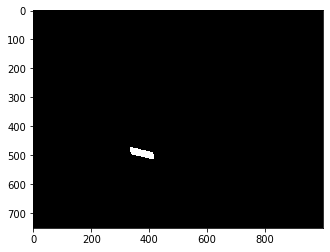

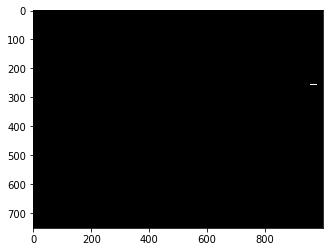

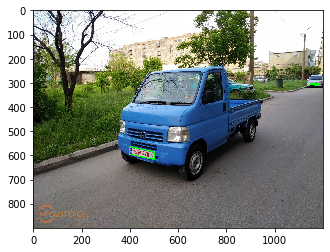

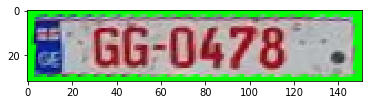

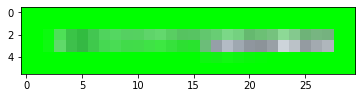

['eu', 'xx_unknown']
['GG0478', '']
NOT OK: TEXT:G60478 			 RESULTS:['GG0478', ''] 
					 in PATH:../datasets/hackaton/ge_test/39408508-39408508_6.jpg 
__________ 		 ../datasets/hackaton/ge_test/39223631-39223631_7.jpg 		 __________


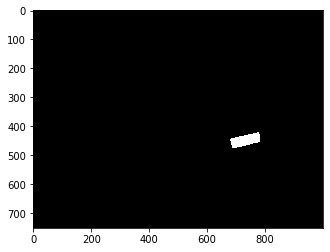

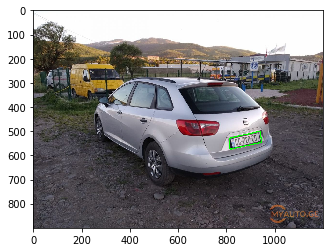

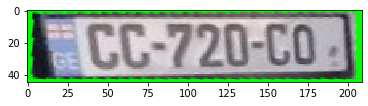

['eu']
['CC720COJ']
NOT OK: TEXT:CC720C0 			 RESULTS:['CC720COJ'] 
					 in PATH:../datasets/hackaton/ge_test/39223631-39223631_7.jpg 
__________ 		 ../datasets/hackaton/ge_test/39335223-39335223_10.jpg 		 __________


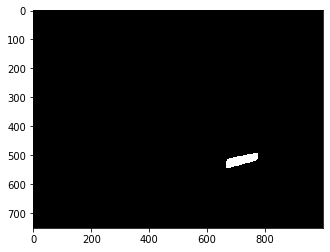

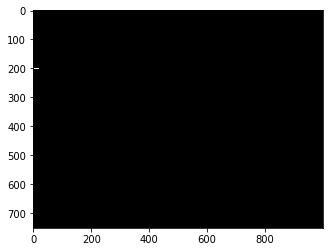

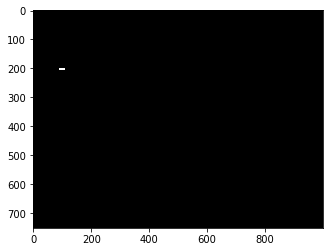

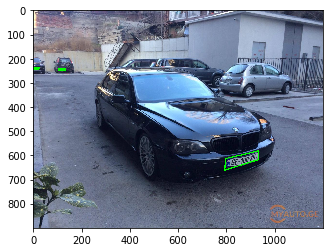

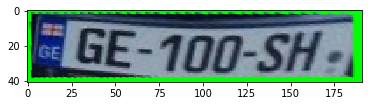

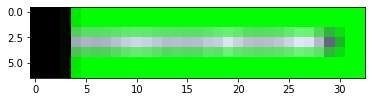

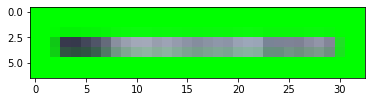

['eu', 'xx_unknown', 'xx_unknown']
['GE1003H', '', '']
NOT OK: TEXT:GE100SH 			 RESULTS:['GE1003H', '', ''] 
					 in PATH:../datasets/hackaton/ge_test/39335223-39335223_10.jpg 
__________ 		 ../datasets/hackaton/ge_test/39283091-39283091_7.jpg 		 __________


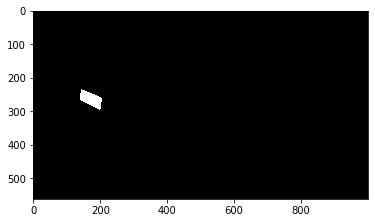

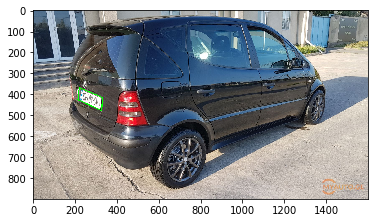

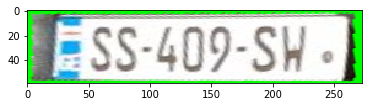

['eu_ua_2015']
['BH4093H']
NOT OK: TEXT:SS409SW 			 RESULTS:['BH4093H'] 
					 in PATH:../datasets/hackaton/ge_test/39283091-39283091_7.jpg 
__________ 		 ../datasets/hackaton/ge_test/39197303-39197303_5.jpg 		 __________


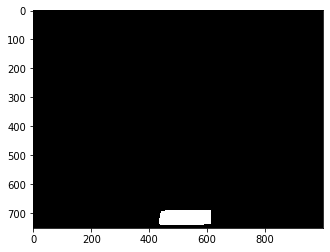

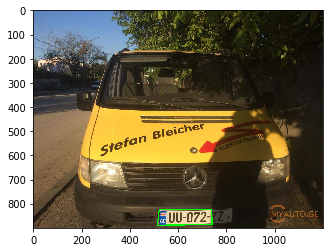

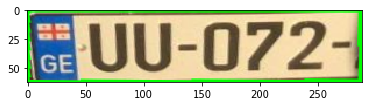

['eu']
['UU072']
NOT OK: TEXT:UU072ZZ 			 RESULTS:['UU072'] 
					 in PATH:../datasets/hackaton/ge_test/39197303-39197303_5.jpg 
__________ 		 ../datasets/hackaton/ge_test/38470079-38470079_1.jpg 		 __________


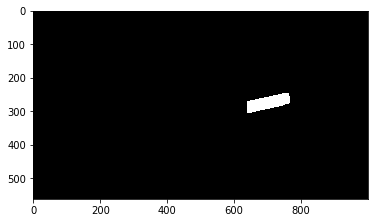

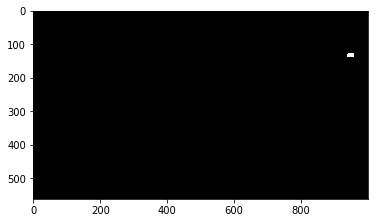

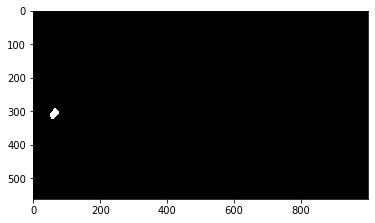

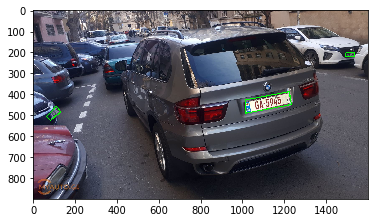

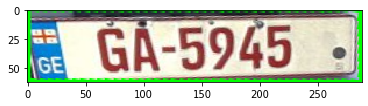

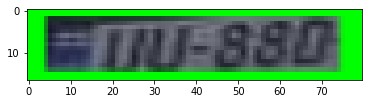

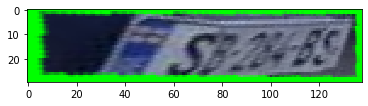

['eu', 'xx_unknown', 'xx_unknown']
['GA594B', '', '']
NOT OK: TEXT:EE392NN 			 RESULTS:['GA594B', '', ''] 
					 in PATH:../datasets/hackaton/ge_test/38470079-38470079_1.jpg 
NOT OK: TEXT:GA5945 			 RESULTS:['GA594B', '', ''] 
					 in PATH:../datasets/hackaton/ge_test/38470079-38470079_1.jpg 
__________ 		 ../datasets/hackaton/ge_test/28996552-28996552_1.jpg 		 __________


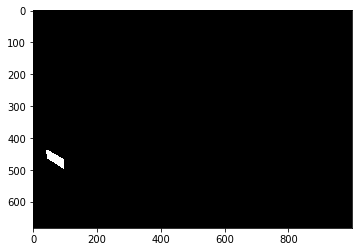

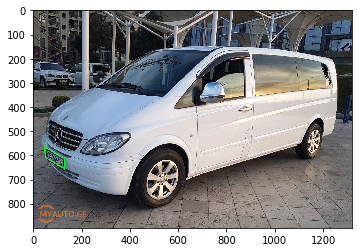

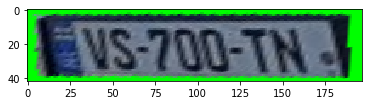

['eu']
['S7003N']
NOT OK: TEXT:VS700TN 			 RESULTS:['S7003N'] 
					 in PATH:../datasets/hackaton/ge_test/28996552-28996552_1.jpg 
__________ 		 ../datasets/hackaton/ge_test/38876241-38876241_1.jpg 		 __________


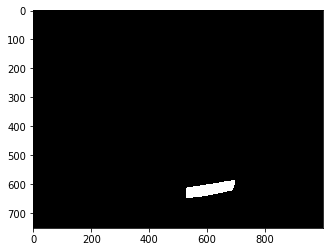

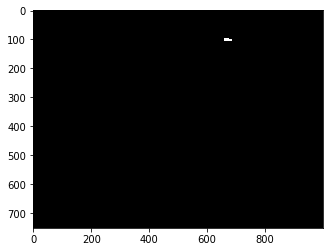

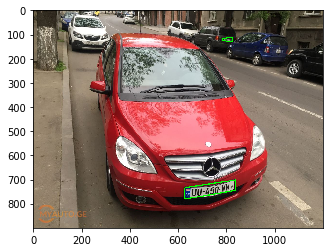

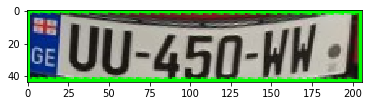

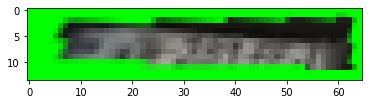

['eu', 'xx_unknown']
['UU450WW', '']
OK: TEXT:UU450WW 			 RESULTS:['UU450WW', ''] 
					 in PATH:../datasets/hackaton/ge_test/38876241-38876241_1.jpg
__________ 		 ../datasets/hackaton/ge_test/39335560-39335560_8.jpg 		 __________


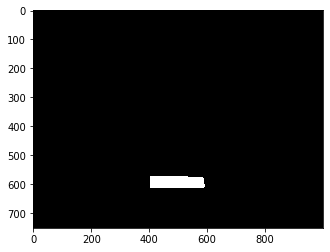

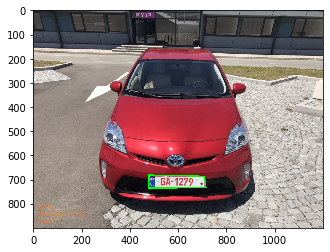

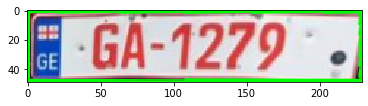

['eu']
['A1279']
NOT OK: TEXT:GA1279 			 RESULTS:['A1279'] 
					 in PATH:../datasets/hackaton/ge_test/39335560-39335560_8.jpg 
__________ 		 ../datasets/hackaton/ge_test/39340309-39340309_4.jpg 		 __________


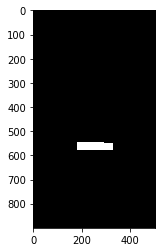

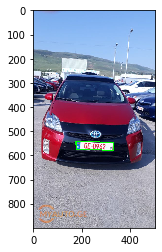

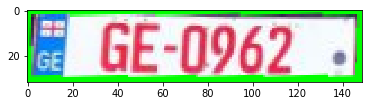

['eu']
['GE0962']
OK: TEXT:GE0962 			 RESULTS:['GE0962'] 
					 in PATH:../datasets/hackaton/ge_test/39340309-39340309_4.jpg
TOTAL GOOD: 0.14285714285714285
TOTAL BED: 0.8571428571428571


In [8]:
testData = {
    "0.jpeg": ["AI5255EI"],
    "1.jpeg": ["HH7777CC"],
    "2.jpeg": ["AT1515CK"],
    "3.jpeg": ["BX0578CE"],
    "4.jpeg": ["AC4249CB"],
    "5.jpeg": ["BC3496HC"],
    "6.jpeg": ["BC3496HC"],
    "7.jpeg": ["AO1306CH"],
    "8.jpeg": ["AE1077CO"],
    "9.jpeg": ["AB3391AK"],
    "10.jpeg": ["BE7425CB"],
    "11.jpeg": ["BE7425CB"],
    "12.jpeg": ["AB0680EA"],
    "13.jpeg": ["AB0680EA"],
    "14.jpeg": ["BM1930BM"],
    "15.jpeg": ["AI1382HB"],
    "16.jpeg": ["AB7333BH"],
    "17.jpeg": ["AB7642CT"],
    "18.jpeg": ["AC4921CB"],
    "19.jpeg": ["BC9911BK"],
    "20.jpeg": ["BC7007AK"],
    "21.jpeg": ["AB5649CI"],
    "22.jpeg": ["AX2756EK"],
    "23.jpeg": ["AA7564MX"],
    "24.jpeg": ["AM5696CK"],
    "25.jpeg": ["AM5696CK"],
}

testData = {'38523092-38523092_1.jpg': ['DD076XX', 'GA2565'],
 '36204663-36204663_6.jpg': ['ZZ202QZ'],
 '39216637-39216637_2.jpg': ['PP564AA'],
 '38297989-38297989_4.jpg': ['SJ909SS'],
 '29154782-29154782_7.jpg': ['SP051SS'], # -
 '38538422-38538422_1.jpg': ['BS227BS'],
 '39008915-39008915_1.jpg': ['WW613YY'],
 '39381711-39381711_1.jpg': ['GA3627'],
 '38685784-38685784_5.jpg': ['FF024GG'],
 '37230942-37230942_3.jpg': ['MM505QQ'],
 '39390449-39390449_2.jpg': ['SS040SQ'],# update
 '39417779-39417779_1.jpg': ['VZV763', 'NVN161'],#add 1
 '39229983-39229983_5.jpg': ['XV111T0'],
 '39196372-39196372_5.jpg': ['0I128II'],
 '39194553-39194553_4.jpg': ['GE6751'], # update
 '39408508-39408508_6.jpg': ['G60478'],
 '39223631-39223631_7.jpg': ['CC720C0'],
 '39335223-39335223_10.jpg': ['GE100SH'],
 '39283091-39283091_7.jpg': ['SS409SW'],
 '39197303-39197303_5.jpg': ['UU072ZZ'], # remove
 '38470079-38470079_1.jpg': ['EE392NN', 'GA5945'],
 '28996552-28996552_1.jpg': ['VS700TN'], # update
 '38876241-38876241_1.jpg': ['UU450WW'],
 '39335560-39335560_8.jpg': ['GA1279'], # update
 '39340309-39340309_4.jpg': ['GE0962']} # update


gGood = 0
gBad = 0
i = 0
for fileName in testData.keys():
    nGood, nBad = await test(dirName, fileName, testData[fileName], verbose=1)
    gGood += nGood
    gBad += nBad
    i += 1
total = gGood + gBad
print(f"TOTAL GOOD: {gGood/total}")
print(f"TOTAL BED: {gBad/total}")

In [ ]:
await test(dirName, "12.jpeg", ["AB0680EA"], verbose=1, max_img_w = 1200)